# Algorithm to optimize phase mask

In [8]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
sys.path.append("../core/")
from pupil_masks import *
from optim_functions import *
import os


In [9]:
%matplotlib notebook

## RUN

81


../core/pupil_masks.py:260: RuntimeWarning: overflow encountered in power
  Pupil = np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**500)


<IPython.core.display.Javascript object>


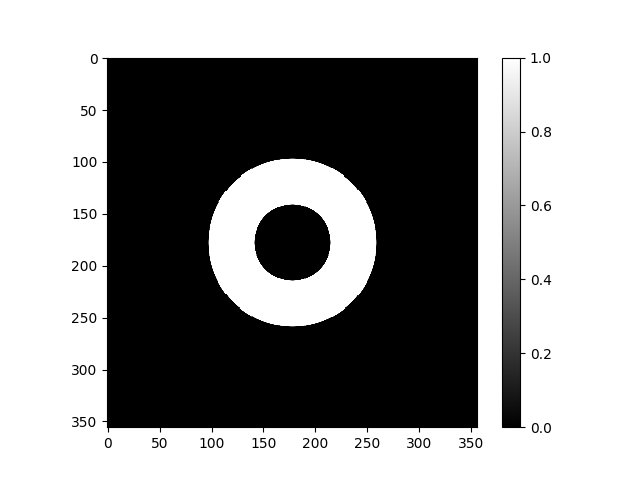

In [10]:
N = 4096
x = np.arange(-N/2, N/2)
y = np.arange(-N/2, N/2)
X, Y = np.meshgrid(x,y)

RHO, THETA = cart2pol(X,Y) 

lambdaOverD = 25
apRad = int(N/(2*lambdaOverD))
print(int(apRad))
# choose entrance pupil 
#EP = fits.getdata('VLT_pupil_N=512_apRad_250.0.fits')

EP = make_customPalomar_pupil(1024, apRad, (1.75, 0.8, 0.1), spiders=False)
EP = np.lib.pad(EP, (1536, 1536), 'constant', constant_values=(0,0))
#LS = make_elliptical_pupil(1024, 1.0, apRad)
#LS = np.lib.pad(LS, (1536, 1536), 'constant', constant_values=(0,0))
LS = EP
FPM_init = np.exp(1j*2*THETA)
FP = myfft2(EP)*FPM_init
LP = myifft2(FP)

plot_im_LP(EP, apRad, 1.2)

### Optimized phase mask calculation

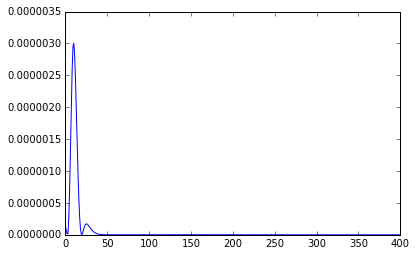

In [14]:
normI = np.max(np.max(abs(myfft2(EP))**2))  # Irradiance normalization

charge = 2
FPM_init = np.exp(1j*charge*THETA)

OPT_REG_FP = np.ones((N,N))

#LS=EP
OPT_REG_LP = LS

max_its = 400
goal_leak = 1e-6
FPM,FPC,its,leak = calcMask(EP, FPM_init, LS, OPT_REG_FP, OPT_REG_LP, max_its, goal_leak )


### Phase mask import

### Optimized Phase Mask (no circular symmetry imposed)

400 1.5573784656e-11


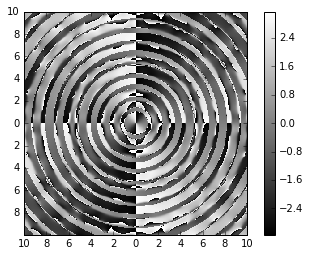

In [15]:
print(its, leak)
plot_im_ld(np.angle(FPM), 25, 10, color='gray')

### Lyot plane of the VLT pupil with Lyot stop and vortex phase mask 

/home/patapisp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.208088166057


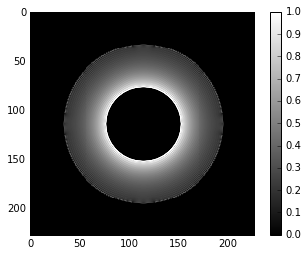

In [16]:
PSF = myfft2(EP)
FP = PSF*FPM_init
LPj = myifft2(FP)
LPj_stop = LPj*LS
plot_im_LP(abs(LPj_stop), apRad, 0.4)
print(throughputLP(abs(LPj), LS, EP))
#hdu.writeto('PSF_VLT.fits')

### Lyot plane  of the VLT pupil with Lyot stop and optimized phase mask 

/home/patapisp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


2.76333382958e-08


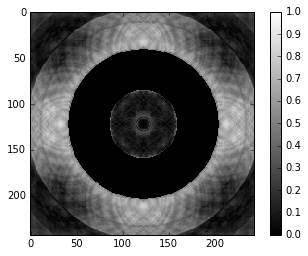

In [17]:
PSF_c = myfft2(EP)
FP_c = PSF_c*FPM
LPj_c = myifft2(FP_c)
LPj_stop_c = LPj_c*LS
plot_im_LP(abs(LPj_c), apRad, 0.5)
through = np.sum(abs(LPj_stop_c))**2/np.sum(abs(LPj_stop))**2
print(through)


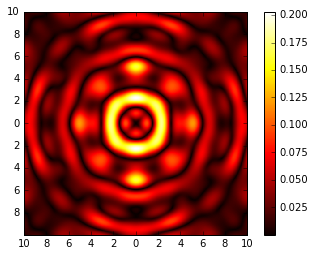

In [18]:
PSFopt = abs(myfft2(LPj_stop_c))
plot_im_ld(PSFopt, 25, 10)

### Lyot plane of the VLT pupil with spiders and opt PM w/o spiders

/home/patapisp/Documents/pyNodal/pupil_masks.py:121: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))*spider1*spider2*spider3*spider4


0.0807409149304


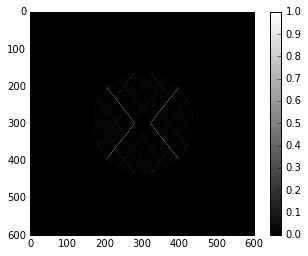

In [15]:
EP_sp = make_VLT_pupil(1024, apRad, spiders=True)
EP_sp = np.lib.pad(EP_sp, (1536, 1536), 'constant', constant_values=(0,0))
PSF_sp = myfft2(EP_sp)
FP_sp = PSF_sp*FPM
LPj_sp = myifft2(FP_sp)
LPj_stop_sp = LPj_sp*LS
plt.imshow(abs(LPj_stop_sp[1748:2348,1748:2348]),interpolation='nearest', cmap='gray', vmin=0, vmax=1)
plt.colorbar()
through_sp = np.sum(abs(LPj_stop_sp))**2/np.sum(abs(LPj_stop))**2
print(through_sp)
PSFout_sp = myfft2(LPj_stop_sp)
#hdu.writeto('LP_N4096_VLT_spiders.fits')

### PSF of the VLT pupil with the opt. mask

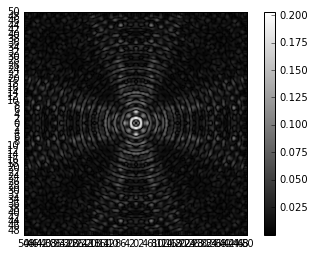

In [19]:
PSFout = myfft2(LPj_stop_c)
plot_im_ld(abs(PSFout), 25, 50 ,color='gray')

### Save simulation files

In [20]:
sim_id = 'SIM020'
try:
    os.mkdir("Simulations/%s"%sim_id)
    path = "Simulations/%s"%sim_id
    
    # Optimized focal plane mask
    hdu = fits.PrimaryHDU(data=np.angle(FPM))
    hdu.header['ID'] = sim_id    
    hdu.header['PUPIL']='PAL -c -s'
    hdu.header['TYPE']='Vortex m=2'    
    hdu.header['LS']='PAL -c -s'
    hdu.header['LD'] = str(lambdaOverD)
    hdu.header['apRad']=str(apRad)
    hdu.header['DIM'] = "1.75, 0.8, 0.1"
    hdu.writeto(os.path.join(path,'FPM_%s.fits'%sim_id))
    # Lyot plane 
    hdu = fits.PrimaryHDU(data=abs(LPj_c))
    hdu.header['PUPIL']= 'PAL -c -s'
    hdu.header['apRad'] = str(apRad)
    hdu.header['LD'] = str(lambdaOverD)
    hdu.header['LS']='PAL -c -s'
    hdu.header['DIM'] = "1.75, 0.8, 0.1"    
    hdu.header['THROU'] = str(through)
    hdu.header['FPM']='FPM_%s.fits'%sim_id
    hdu.writeto(os.path.join(path,'LP_%s.fits'%sim_id))
    # Focal plane after Lyot stop
    hdu = fits.PrimaryHDU(data=abs(PSFout))
    hdu.header['PUPIL']= 'PAL -c -s'
    hdu.header['LD'] = str(lambdaOverD)
    hdu.header['LS']='PAL -c -s'
    hdu.header['DIM'] = "1.75, 0.8, 0.1"
    hdu.header['FPM']='FPM__%s.fits'%sim_id
    hdu.writeto(os.path.join(path,'PSF_%s.fits'%sim_id))
    
    """# Lyot plane 
    hdu = fits.PrimaryHDU(data=abs(LPj_sp))
    hdu.header['PUPIL']= 'VLT'
    hdu.header['apRad'] = str(apRad)
    hdu.header['LD'] = str(lambdaOverD)
    hdu.header['LS']='VLT -s'
    hdu.header['THROU'] = str(through_sp)
    hdu.header['FPM']='FPM_%s.fits'%sim_id
    hdu.writeto(os.path.join(path,'LP_spiders_%s.fits'%sim_id))
    # Focal plane after Lyot stop
    hdu = fits.PrimaryHDU(data=abs(PSFout_sp))
    hdu.header['PUPIL']= 'VLT'
    hdu.header['LD'] = str(lambdaOverD)
    hdu.header['LS']='VLT -s'
    hdu.header['FPM']='FPM__%s.fits'%sim_id
    hdu.writeto(os.path.join(path,'PSF_spiders_%s.fits'%sim_id))"""
except:
    print('Directory %s already exists'%sim_id)
    
    


In [35]:
path = 'Simulations/SIM005/'
mask_name = 'FPM_SIM005'

downsample_mask(path, mask_name)

array([[173, 163, 141, ..., 125, 111,  89],
       [186, 156, 105, ..., 156, 141,  89],
       [230, 230,  74, ..., 179, 171,  26],
       ..., 
       [  1, 227, 201, ...,  63,  53,  25],
       [ 28,  30, 179, ...,  76,  79, 225],
       [ 68,  95, 145, ...,  98, 111, 161]], dtype=uint8)

## Throughput

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 4096                                                  NAXIS2  =                 4096                                                  EXTEND  =                    T                                                  PUPIL   = 'PALOMAR custom -s'                                                   LD      = '26      '                                                            LS      = 'CIRC    '                                                            FPM     = 'FPM__SIM022.fits'                                                    DIMS    = 'outer_diam: 3mm, inner_diam: 1.1mm, spider_width: 0.5mm'             END                                                                                                                     

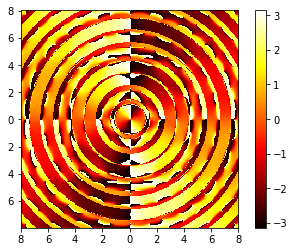

In [5]:
path = r'C:\Users\Chronis\Documents\Ambizione Project\Master project\pyNodal\SIM022'
mask = fits.getdata(os.path.join(path,'FPM_SIM022.fits'))
h = fits.getheader(os.path.join(path,'PSF_SIM022.fits'))
print(h)
plot_im_ld(mask, 25, 8)

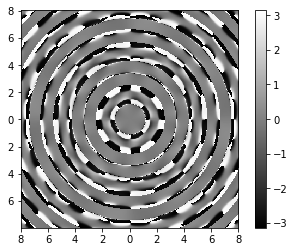

In [7]:
corr = np.exp(1j*mask - 1j*2*THETA)
plot_im_ld(np.angle(corr), 25, 8, color='gray')

/home/patapisp/Documents/pyNodal/pupil_masks.py:168: RuntimeWarning: overflow encountered in power
  Pupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**500))*spider1*spider2
/home/patapisp/Documents/pyNodal/pupil_masks.py:45: RuntimeWarning: overflow encountered in power
  pupil = np.exp(-np.sqrt((X/a)**2 + (Y/b)**2)**1000)


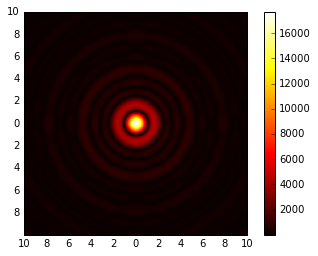

In [22]:
N = 4096
x = np.arange(-N/2, N/2)
y = np.arange(-N/2, N/2)
X, Y = np.meshgrid(x,y)

RHO, THETA = cart2pol(X,Y) 

lambdaOverD = 25
apRad = int(N/(2*lambdaOverD))
# choose entrance pupil 
#EP = fits.getdata('VLT_pupil_N=512_apRad_250.0.fits')

EP = make_Palomar_pupil(1024, apRad)
EP = np.lib.pad(EP, (1536, 1536), 'constant', constant_values=(0,0))
LS =  make_elliptical_pupil(1024, 1.0, apRad)
LS = np.lib.pad(LS, (1536, 1536), 'constant', constant_values=(0,0))
PSF1 = myfft2(EP)
FPM_init = np.exp(1j*2*THETA)
FP = myfft2(EP)*FPM_init
LP = myifft2(FP)
PSF2 = myfft2(LP*LS)
plot_im_ld(abs(PSF1), 25, 10)

0.0108731695144
0.139581654739


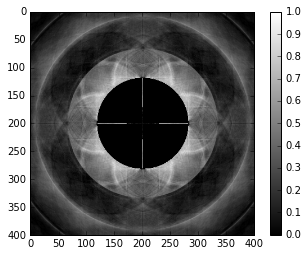

In [25]:
FP_opt = myfft2(EP)*np.exp(1j*mask)
LP_otp = myifft2(FP_opt)
plt.imshow(abs(LP_otp[1848:2248, 1848:2248]), vmin=0, vmax=1, cmap='gray')
plt.colorbar()
print(throughputLP(abs(LP_otp), LS, EP))
print(throughputLP(abs(LP), LS, EP))

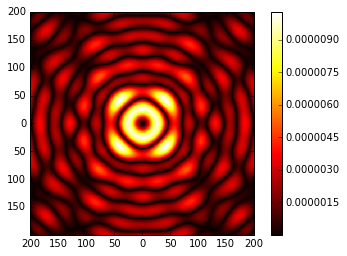

In [44]:
psf_norm = psf/abs(PSF1[2048,2048])
plot_im_ld(psf_norm, 25, 8)
hdu = fits.PrimaryHDU(data=psf_norm)
hdu.header = h
hdu.writeto(os.path.join(path, 'PSF_norm_SIM013.fits'))

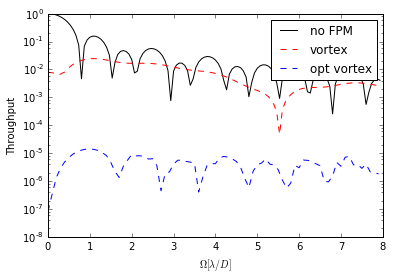

In [73]:
path = 'Simulations/SIM003/PSF_SIM003.fits'
h = fits.getheader(path)
psf = fits.getdata(path)
x3,f3 =calculate_contrast_curve(psf, int(h['lD']))
x2, f2 = calculate_contrast_curve(abs(PSF2), 15)
x1, f1 = calculate_contrast_curve(abs(PSF1), 15)

plt.semilogy(x1, f1/f1[0], 'black', label='no FPM') 
plt.semilogy(x2,f2/f1[0], 'r--', label='vortex')
plt.semilogy(x3, f3/f1[0], 'b--', label='opt vortex')
plt.ylabel("Throughput")
plt.xlabel("$\Omega [\lambda /D]$")
plt.legend()
plt.savefig('Simulations/SIM003/Contrast_curve_nospiders')

## Computed optimized phase mask

/home/patapisp/Documents/pyNodal/pupil_masks.py:121: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))*spider1*spider2*spider3*spider4
/home/patapisp/Documents/pyNodal/pupil_masks.py:138: RuntimeWarning: overflow encountered in power
  return np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200)
/home/patapisp/Documents/pyNodal/pupil_masks.py:45: RuntimeWarning: overflow encountered in power
  pupil = np.exp(-np.sqrt((X/a)**2 + (Y/b)**2)**1000)


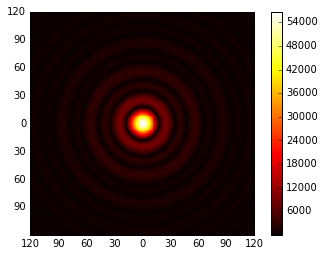

In [47]:
N = 4096
x = np.arange(-N/2, N/2)
y = np.arange(-N/2, N/2)
X, Y = np.meshgrid(x,y)

RHO, THETA = cart2pol(X,Y) 

lambdaOverD = 15
apRad = int(N/(2*lambdaOverD))
# choose entrance pupil 
#EP = fits.getdata('VLT_pupil_N=512_apRad_250.0.fits')

EP = make_VLT_pupil(1024, apRad, spiders=False)
EP = np.lib.pad(EP, (1536, 1536), 'constant', constant_values=(0,0))
LS =  make_elliptical_pupil(1024, 1, apRad)
LS = np.lib.pad(LS, (1536, 1536), 'constant', constant_values=(0,0))
PSF1 = myfft2(EP)
FPM_init = np.exp(1j*2*THETA)
FP = myfft2(EP)*FPM_init
LP = myifft2(FP)
PSF2 = myfft2(LP*LS)
plot_im_ld(abs(PSF1), 15, 8)

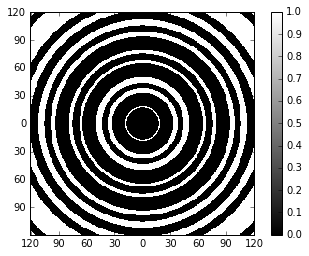

In [48]:
LD = RHO/15
mask = np.angle(FPM_init)
rotated = np.rot90(mask)
overlay1 = abs(PSF1)
overlay2 = abs(PSF1)
overlay1[overlay1<=2000] = 1
overlay1[overlay1>2000] = 0
overlay2[np.where(abs(PSF1)>500)] = 0
overlay2[np.where(abs(PSF1)<=500)] = 1
overlay2[np.where(RHO<50)] = overlay1[np.where(RHO<50)]
overlay2[np.where(RHO>200)]=0
plot_im_ld(overlay2, 15, 8, color='gray')
#1948:2148,1948:2148

In [49]:
mask[np.where(overlay2 ==1)] = rotated[np.where(overlay2==1)]

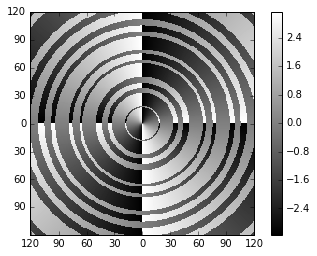

In [50]:
plot_im_ld(mask, 15, 8, color='gray')

/home/patapisp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.034260809991970599

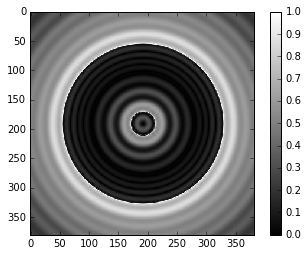

In [51]:
FP = myfft2(EP)*np.exp(1j*mask)
LP = myifft2(FP)
plot_im_LP(abs(LP), apRad, 0.4)
throughputLP(abs(LP), LS, EP)

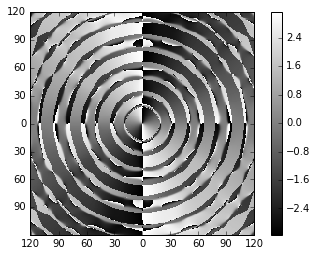

In [42]:
path = 'Simulations/SIM006/'
FPM = fits.getdata(os.path.join(path, 'FPM_SIM006.fits'))
plot_im_ld(FPM, 15, 8, color='gray')

## 8bit demo

/home/patapisp/Documents/pyNodal/pupil_masks.py:121: RuntimeWarning: overflow encountered in power
  VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))*spider1*spider2*spider3*spider4
/home/patapisp/Documents/pyNodal/pupil_masks.py:45: RuntimeWarning: overflow encountered in power
  pupil = np.exp(-np.sqrt((X/a)**2 + (Y/b)**2)**1000)
/home/patapisp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


5.2265359811346315e-07

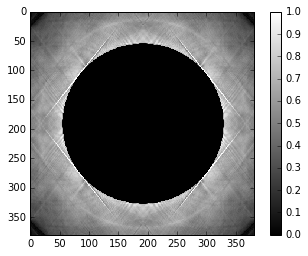

In [46]:
path = 'Simulations/SIM006/'
FPM = fits.getdata(os.path.join(path, 'FPM_SIM006.fits'))
FPM8bit = fits.getdata(os.path.join(path, 'FPM_SIM006_8bit.fits'))


N = 4096
x = np.arange(-N/2, N/2)
y = np.arange(-N/2, N/2)
X, Y = np.meshgrid(x,y)

RHO, THETA = cart2pol(X,Y) 

lambdaOverD = 15
apRad = int(N/(2*lambdaOverD))
# choose entrance pupil 
#EP = fits.getdata('VLT_pupil_N=512_apRad_250.0.fits')

EP = make_VLT_pupil(1024, apRad, spiders=True)
EP = np.lib.pad(EP, (1536, 1536), 'constant', constant_values=(0,0))
LS = make_elliptical_pupil(1024, 1, apRad)
LS = np.lib.pad(LS, (1536, 1536), 'constant', constant_values=(0,0))

FP = myfft2(EP)*np.exp(1j*FPM)
LP = myifft2(FP)
PSF = myfft2(LP)
plot_im_LP(abs(LP), apRad, 0.4)
throughputLP(abs(LP), LS, EP)

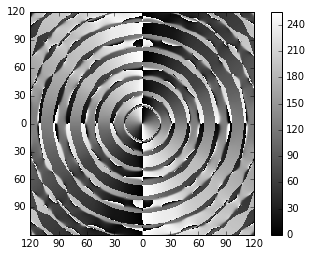

In [15]:
plot_im_ld(FPM8bit, 15, 8, color='gray')

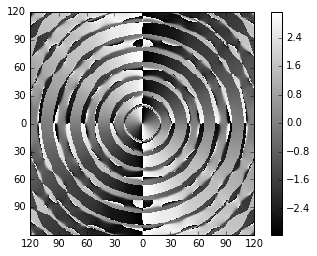

In [18]:
FPM8bit_f = (FPM8bit/255)*2*np.pi- np.pi
plot_im_ld(FPM8bit_f, 15, 8, color='gray')

/home/patapisp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1.8559567470381987e-05

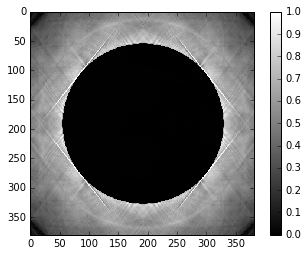

In [45]:
FP8bit = myfft2(EP)*np.exp(1j*FPM8bit_f)
LP8bit = myifft2(FP8bit)
plot_im_LP(abs(LP8bit), apRad, 0.4)
throughputLP(abs(LP8bit), LS, EP)